[Voronoi tessellation](https://en.wikipedia.org/wiki/Voronoi_diagram) is a process of partitioning the plane into polygons based on the distances between points of the plane and selected seed points. Voronoi diagrams are often plotted with random color, and some GPU techniques can make their plotting pretty fast.

Colors of each polygon are usually selected randomly but it can be fun to select for each seed the color of of the corresponding pixel in a piece of art.

Let's explore with the Voronoi implementation in scipy.

[]

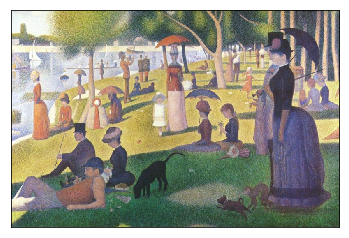

In [70]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2

from scipy.spatial import Voronoi

img = cv2.imread("seurat.jpg")[::-1, :, ::-1]
size_y, size_x, _ = img.shape

plt.imshow(img, origin="up")

In [71]:
# let's stick to a fixed number of seeds
nb_points = 1500

In [72]:
def plot_voronoi(ax, img, x, y):

    points = np.c_[x, y]
    voronoi = Voronoi(points)

    for region_idx, (x, y) in zip(voronoi.point_region, points):
        region = voronoi.regions[region_idx]
        if not -1 in region:
            polygon = [voronoi.vertices[i] for i in region]
            color = "#{:02x}{:02x}{:02x}".format(*img[y, x, :])
            ax.fill(*zip(*polygon), color=color)

    ax.set_xlim((0, size_x))
    ax.set_ylim((0, size_y))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect(1)

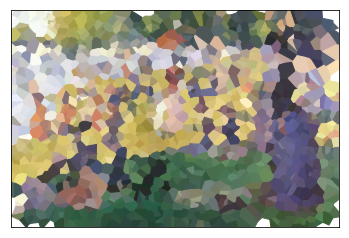

In [73]:
ax = plt.axes()
x = np.random.randint(0, size_x, nb_points)
y = np.random.randint(0, size_y, nb_points)
plot_voronoi(ax, img, x, y)

The sampling of the 1500 seeds in the image is uniform, but maybe we can try to do better. What if we could select more points in areas with more details. Let's have a look at edge detection by [Laplacian and Sobel methods](http://www.aishack.in/tutorials/sobel-laplacian-edge-detectors/).

In [81]:
# it works better with two gaussian blurs before and after the edge detection
k = np.ones((5, 5), np.float32) / 25
edge_detection = cv2.filter2D(
    cv2.Laplacian(cv2.filter2D(img, -1, k), -1).max(axis=2), -1, k
)

[]

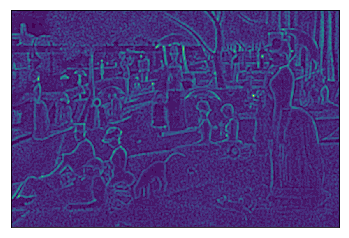

In [82]:
plt.imshow(edge_detection, origin="up")

In [83]:
# the .5 is a good compromise: we still want some points in the areas with less edges
sampling_prob = edge_detection.ravel() + .5
idx = np.random.choice(
    sampling_prob.size,
    nb_points,
    replace=False,
    p=sampling_prob / sampling_prob.sum(),
)
x_edge, y_edge = idx % size_x, idx // size_x

We can check the sampling with more points in interesting regions.

(0, 530)

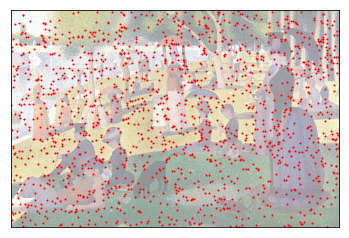

In [84]:
plt.imshow(img, origin="up", alpha=.5)
plt.scatter(x_edge, y_edge, s=1, color="red")

Now it is interesting to compare the two different tessellations.

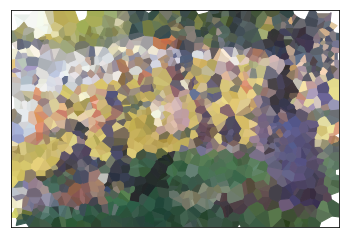

In [85]:
ax = plt.axes()
plot_voronoi(ax, img, x_edge, y_edge)

The result is not that bad on various pieces. Please share your best results!

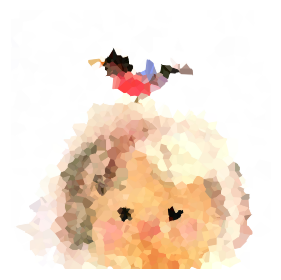

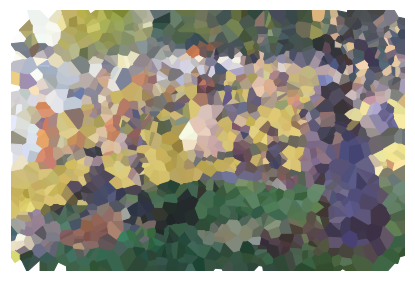

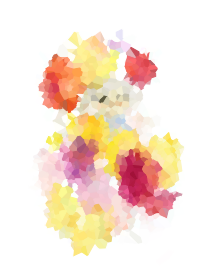

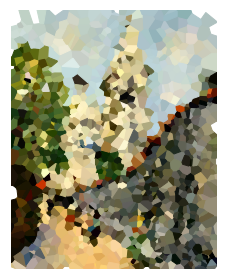

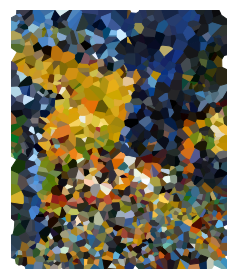

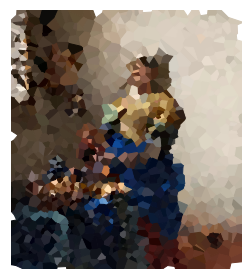

In [105]:
from pathlib import Path

for file in Path(".").glob(
    "../docs/repository/xoolive.github.io/images/voronoi_original/*.jpg"
):
    img = cv2.imread(file.as_posix())[::-1, :, ::-1]
    size_y, size_x, _ = img.shape

    edge_detection = cv2.filter2D(
        cv2.Laplacian(cv2.filter2D(img, -1, k), -1).max(axis=2), -1, k
    )

    sampling_prob = edge_detection.ravel() + .5
    idx = np.random.choice(
        sampling_prob.size,
        nb_points,
        replace=False,
        p=sampling_prob / sampling_prob.sum(),
    )
    x_edge, y_edge = idx % size_x, idx // size_x

    fig, ax = plt.subplots()
    plot_voronoi(ax, img, x_edge, y_edge)
    ax.set_frame_on(False)
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
    fig.tight_layout()
    fig.savefig(
        file.parent.parent / "voronoi_destination" / file.name,
        bbox_inches="tight",
    )